In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc3 as pm
import arviz as az

sns.set_style("whitegrid")

# Обобщение линеных моделей

Мы рассмотрим следующие  модели:
* обобщенные лтнейные модели;
* логистическая регрессия и функции обратной связи;
* простая логистическая регрессия;
* множественная логистическая регрессия;
* функция softmax и мультиноминальная логистическая регрессия;
* регрессия Пуассона;
* регрессия Пуассона с дополнением нулевыми значениями.

## Обобщенные линейные модели

Основная идея данного раздела заключается в идее, что для прогнозирования среднего значения выходной переменной можно применить произвольно выбранную функцию к линейной комбинации входной переменной:
$$\nu = f(\alpha+X\beta)$$
здесь $f$ – функция, которую мы будем называть функцией обратной связи (inverse link function). Существует множество функций обратной связи, которые можно выбрать. Вероятно, самой простой является функция тождественного отображения, то есть функция, возвращающая значение, которое было передано в нее как аргумент. 

Все модели рассмотренные на предидущем занятии использовали тождественное отображение. Само по себе тож- дественное упрощение не очень полезно, но оно позволяет интерпретировать различные модели более обобщенным способом.

Одним из случаев, когда требуется использование функции обратной связи, является работа с категориальными переменными, такими как обозначение цвета, пол, биологические виды или политические партии/принадлежность к ним. Ни одну из таких переменных невозможно правильно смоделировать с помощью нормально распределения. Теоретически нормальное распределение эффективно работает для непрерывной переменной, принимающей любое значение на оси действительных чисел, но вышеупомянутые переменные дискретны и принимают только несколько конкретных значений (например, красный, зеленый, синий – для цвета).

При изменении распределения, используемого для моделирования данных, необходимо также изменить способ мо- делирования вероятных значений для средней величины этих распределений. <br>
Например, если используется биномиальное распределение, то потребуется линейная модель, которая возвращает среднее значение в интервале [0, 1]. <br>
Одним из способов достижения этой цели является сохранение линейной модели с использованием функции обратной связи для ограничения выходного значения требуемым интервалом. Этот прием может применяться не только к дискретным переменным – может возникнуть необходимость моделирования данных, принимающих только положительные значения, следовательно, линейная модель должна быть ограничена, чтобы возвращать только положительные значения средней величины распределения, как, например, гамма-распределение или экспоненциальное распределение.

## Логистическая регрессия

Задачи регрессии относятся к прогнозированию непрерывного значения для выходной переменной на основе значений одной или нескольких входных переменных. В противоположность этому классификация занимается присваиванием дискретного значения (представляющего дискретный класс) выходной переменной на основе значений некоторых входных переменных. 
В обоих случаях задача состоит в том, чтобы получить модель, которая правильно формирует отображение соответствий между входными и выходными переменными. Чтобы добиться этого, необходимо иметь в своем распоряжении выборку с корректно определенными парами входных-выходных переменных. 
С точки зрения машинного обучения регрессии и классификации являются экземплярами алгоритмов обучения с учителем.

Модель логистической регрессии – это обобщение модели линейной регрессии,  отсюда такое название. Такое обобщение производится посредством замены функции $f$  на логистическую функцию как функцию обратной связи:
$$ logistic(z) = \cfrac{1}{1+e^{-z}} $$

Для достижения нашей цели главным свойством этой логистической функции является то, что она фактически независима от значений ее аргумента $z$, поэтому результатом всегда будет число в интервале $[0,1]$. Таким образом, эту функцию можно рассматривать как удобный способ сжатия или упаковки значений, вычисляемых с помощью линейной модели, в диапазон значений, которые можно передать в распределение Бернулли. Эта логистическая функция также известна под названием сигмоидальная функция или просто сигма-функция, поскольку обладает характерной S-образной формой.

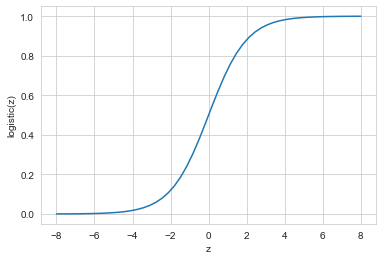

In [2]:
z = np.linspace(-8, 8) 
plt.plot(z, 1 / (1 + np.exp(-z))); 
plt.xlabel('z');
plt.ylabel('logistic(z)');

### Построение логистической модели

Превратим простую линейную модель в простую логистическую регрессию.

Начнем с варианта, в котором существуют только два класса (два типа экземпляров), например неспам/спам, безопасный/небезопасный, облачно/солнечно, здоровый/больной. 
Во-первых, необходимо закодировать эти классы, определив, скажем, что прогнозируемая переменная $y$ может принимать только два значения 0 и 1, то есть $y\in \{0,1\}$. Такую классификацию называют бинарной.<br>
После принятия этого предварительного условия задача становится похожей на пример с подбрасыванием монеты.

Помните, что мы  использовали распределение Бернулли как функцию правдоподобия. Отличие от задачи с подбрасыванием монеты состоит в том, что теперь $\theta$  генерируется не из бета-распределения, а определяется линейной моделью с логистической функцией, используемой как функция обратной связи. В итоге получаем (без известных априорных распределений):
$$ \theta = logistic(\alpha+x\beta)$$
$$ y=Bern(\theta) $$

Воспользуемся уже известным наи набором данных с цветами ириса.

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


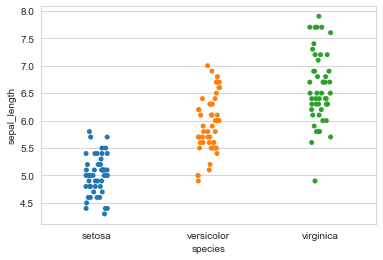

In [3]:
iris = sns.load_dataset("iris")
display(iris.head())
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True);

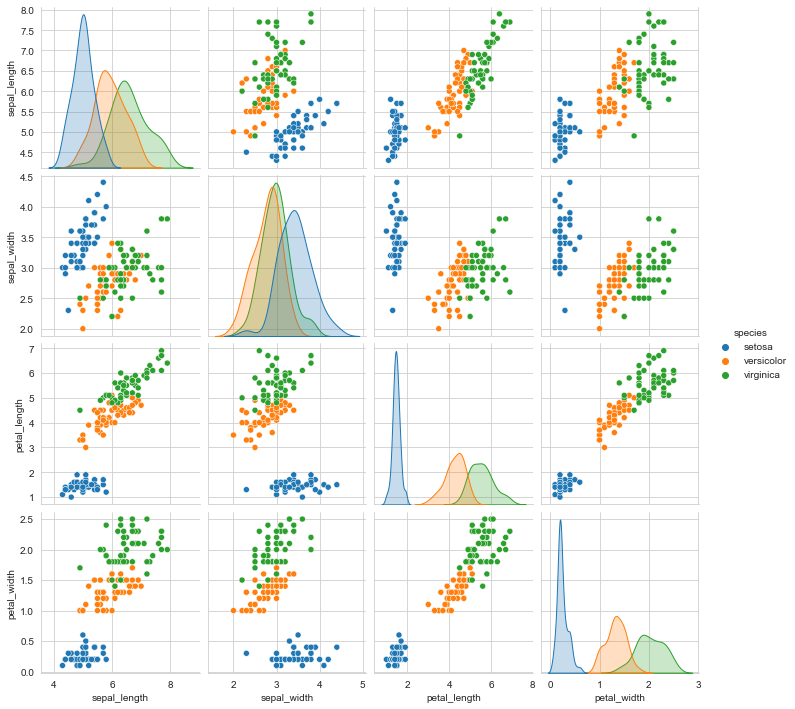

In [4]:
sns.pairplot(iris, hue='species', diag_kind='kde');

Пока мы говорим о модели бинарной классификации. Рассотрим только два типа цветков (setosa и versicolor) только одну независиммую переменную sepal_length (ширина чашелистника).

In [5]:
df = iris.query('species == ("setosa", "versicolor")') 
display(df.head(3))
display(df.tail(3))
y_0 = pd.Categorical(df['species']).codes
column = 'sepal_length'
x_0 = df[column].values
x_c = x_0 - x_0.mean()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
97,6.2,2.9,4.3,1.3,versicolor
98,5.1,2.5,3.0,1.1,versicolor
99,5.7,2.8,4.1,1.3,versicolor


Как и при работе с другими линейными моделями, центрирование данных может помочь при формировании выборок. Сейчас исследуемые данные представлены в корректном формате, поэтому можно сразу перейти к заключительному этапу создания модели с использованием библиотеки PyMC3.

Первая часть модели model_0 напоминает модель линейной регрессии. 

Также обратите внимание на две детерминированные переменные $\theta$ и $ bd $. Переменная $\theta$ – это выходные данные логистической функции, примененной к переменной $\mu$, а $ bd $ – граница решения, то есть значение, используемое для разделения классов.  

Более подробно граница решения рассмотрим несколько позже. Кроме того, заслуживает внимания тот факт, что вместо явной записи логистической функции мы воспользовались функцией pm.math.sigmoid это название логистической функции в библиотеки Theano:

In [18]:
with pm.Model() as model_0:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=20) 
    β = pm.Normal('β', mu=0, sd=10) 
    μ = α_tmp + pm.math.dot(x_c, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    #θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    
    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_0.mean())
    bd = pm.Deterministic('bd', -α/β)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(1000, step, start)



Multiprocess sampling (3 chains in 3 jobs)
NUTS: [β, α_tmp]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 8 seconds.


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


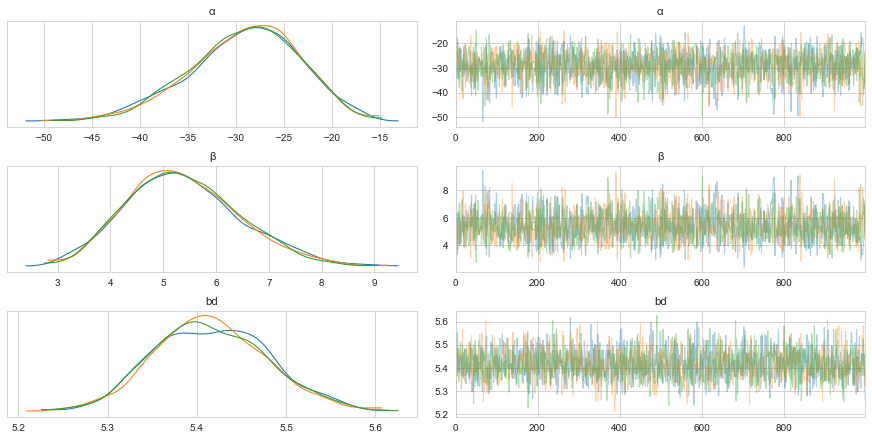

In [19]:
varnames = ['α', 'β', 'bd'];
az.plot_trace(trace_0, varnames);

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


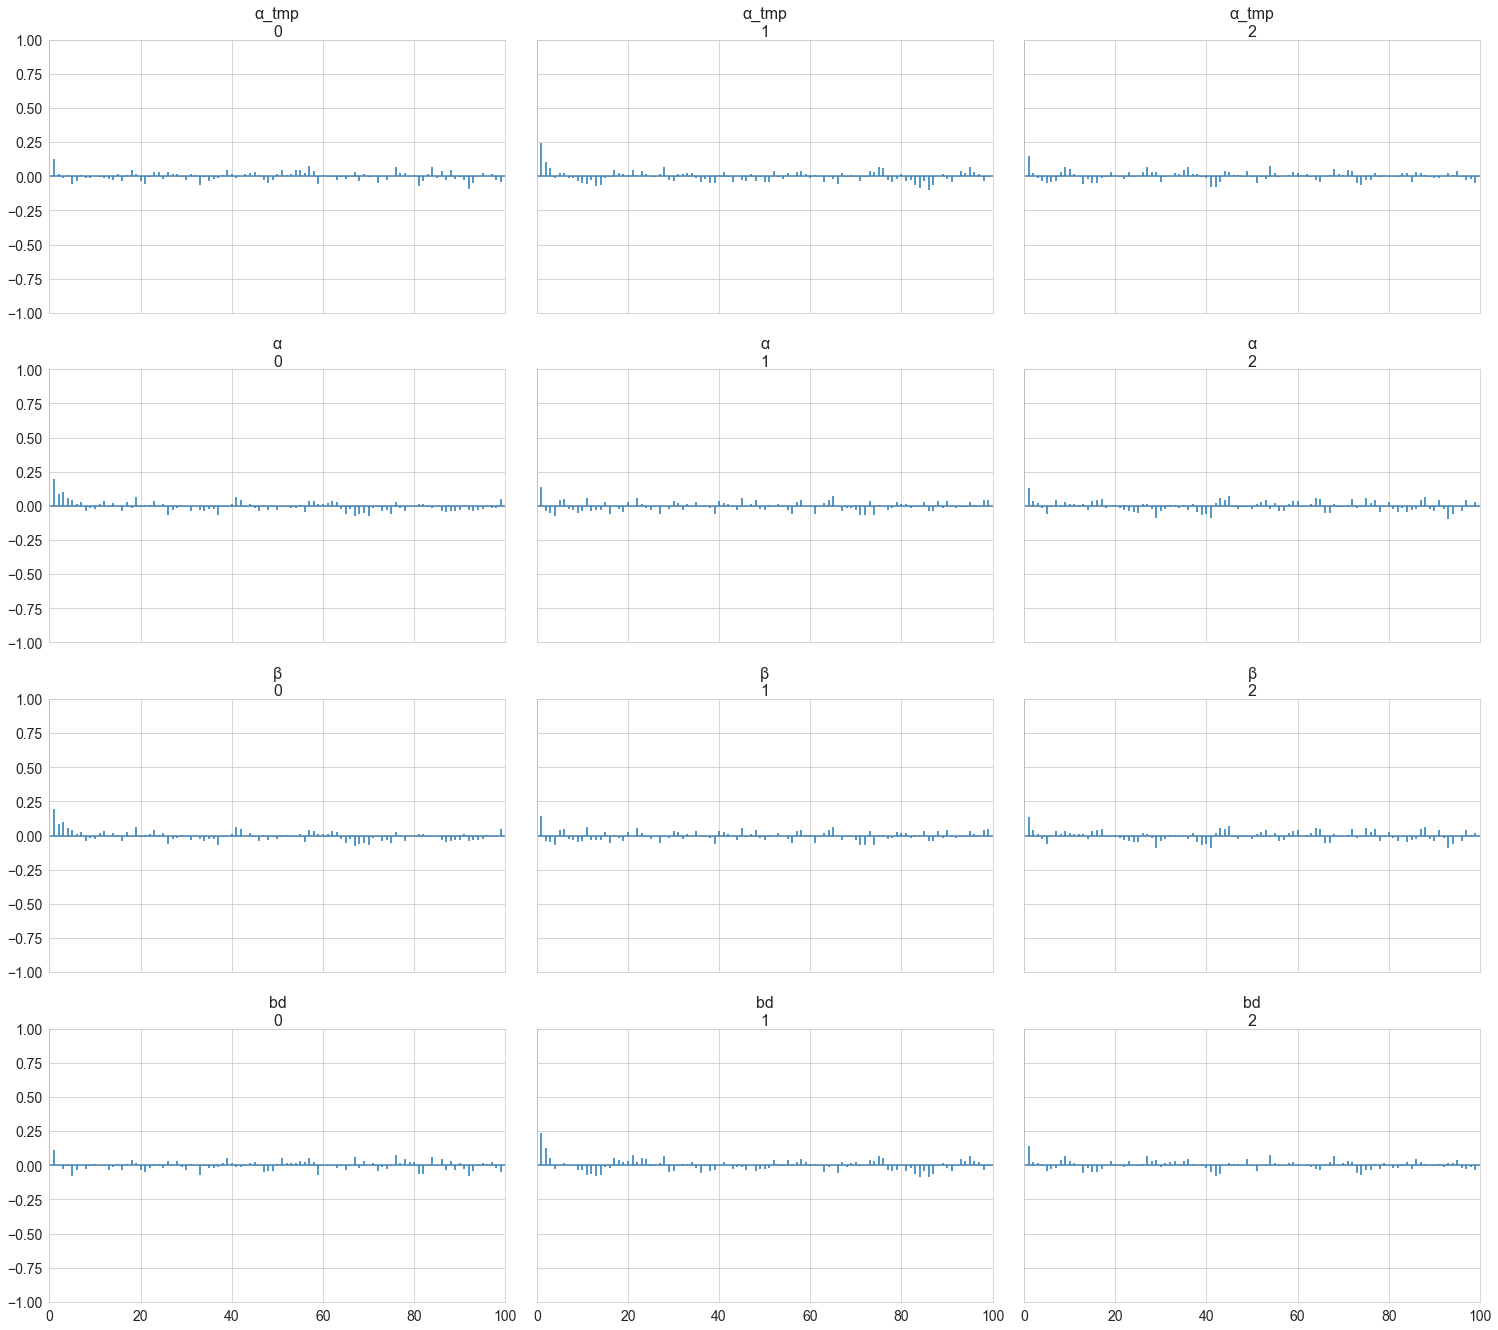

In [20]:
az.plot_autocorr(trace_0, ['α_tmp','α', 'β', 'bd']);

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


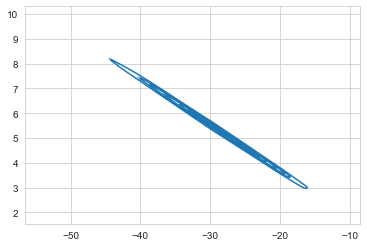

In [21]:
sns.kdeplot(trace_0['α'], trace_0['β']);

In [10]:
az.summary(trace_0, varnames)

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-29.232,5.694,-39.388,-18.717,0.143,0.102,1582.0,1556.0,1591.0,1468.0,1.0
β,5.401,1.057,3.366,7.230,0.027,0.019,1569.0,1537.0,1579.0,1520.0,1.0
bd,5.414,0.063,5.290,5.526,0.001,0.001,2188.0,2188.0,2189.0,1959.0,1.0


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


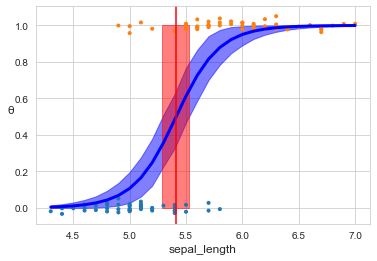

In [11]:
# синий
theta = trace_0['θ'].mean(axis=0)
# синий центр
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
# синий края
theta_hpd = pm.hpd(trace_0['θ'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)


# красный
# красный центр
plt.axvline(trace_0['bd'].mean(), ymin=0, ymax=1, color='r')
# красный края
bd_hpd = pm.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

# точки данных визуально сиещены(разбросаны) по оси y !!!
plt.scatter(x_0, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])


plt.xlabel(column, fontsize=12);
plt.ylabel('θ', rotation=0, fontsize=12);



На схеме показаны данные о длине чашелистика sepal_length по двум видам ирисов (setosa = 0, versicolor = 1). Чтобы избежать чрезмерной плотности и перегруженности диаграммы, бинарные переменные результатов слегка смещены(разбросаны) по высоте, по оси y.

Синяя линяя – это среднее значение $\theta$. Эту линию можно интерпретировать как вероятность того, что цветок принадлежит к виду ирис разноцветный (versicolor), полагая, что нам известно значение длины чашелистиков. Полупрозрачная синяя полоса  – это интервал ПАР 94%.

Значения $x_i$ (в данном примере длины чашелистиков), расположенные слева от границы решения, относятся к классу 0 (setosa), а значения справа от границы решения – к классу 1 (versicolor).

Граница решения определяется как значение $x_i$, для которого $y = 0.5$. Это значение равно отношению $–\cfrac{\alpha}{\beta}$, так как:
* из определения $\theta = logistic(\alpha+x\beta)$;
* очевидно, что если $z=0$, то  $\cfrac{1}{1 + e^{-z}}=0.5$, следовательно $\alpha+x\beta = 0$
* тогда  $x =–\cfrac{\alpha}{\beta}$

Отметим следующие важные факты:
* вообще говоря, значение $\theta$ определяется как $p(y = 1|x)$. В этом смысле логистическая регрессия является истинной регрессией. Главный момент состоит в том, что мы регрессируем вероятность того, что некоторая точка данных принадлежит классу 1 с учетом линейной комбинации признаков;
* здесь моделируется среднее значение бинарной переменной, то есть целое число в интервале [0,1]. Затем вводится правило преобразования этой вероятности в назначение принадлежности одному из двух классов. В рассматриваемом примере если $p(y = 1) \ge 0.5$, то определяется принадлежность классу 1, в противном случае – принадлежность классу 0;
* значение 0.5 не является каким-то особенным, кроме того что это число, находящееся в середине интервала между 0 и 1. Конечно, можно отметить, что эта граница обоснована только в том случае, если ошибки равновероятны в обоих направлениях относительно середины интервала, другими словами, если нет никакой разницы между неправильной классификацией ириса щетинистого (setosa) как ириса разноцветного (versicolor) и ириса разноцветного как ириса щетинистого. Но это не всегда так, и издержки, связанные с неправильной классификацией, не обязательно являются симметричными.

In [12]:
def classify(X, threshold):
    """
    Моя классификационная функция
    """
    X = np.array(X)
    μ = trace_0['α'].mean() + trace_0['β'].mean() * X
    prob = 1 / (1 + np.exp(-μ)) # нельзя использовать pm и threno (X не тензор) 
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([0.09734757, 0.61619901, 0.95984178]), array([False,  True,  True]))

### Примечание

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [β, α]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.664164458556026, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a mode

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-22.956,4.248,-30.725,-15.286,0.294,0.208,209.0,209.0,199.0,93.0,1.02
β,4.239,0.788,2.794,5.641,0.055,0.039,208.0,208.0,199.0,92.0,1.02
bd,5.417,0.072,5.276,5.543,0.002,0.001,1966.0,1950.0,2019.0,1644.0,1.01


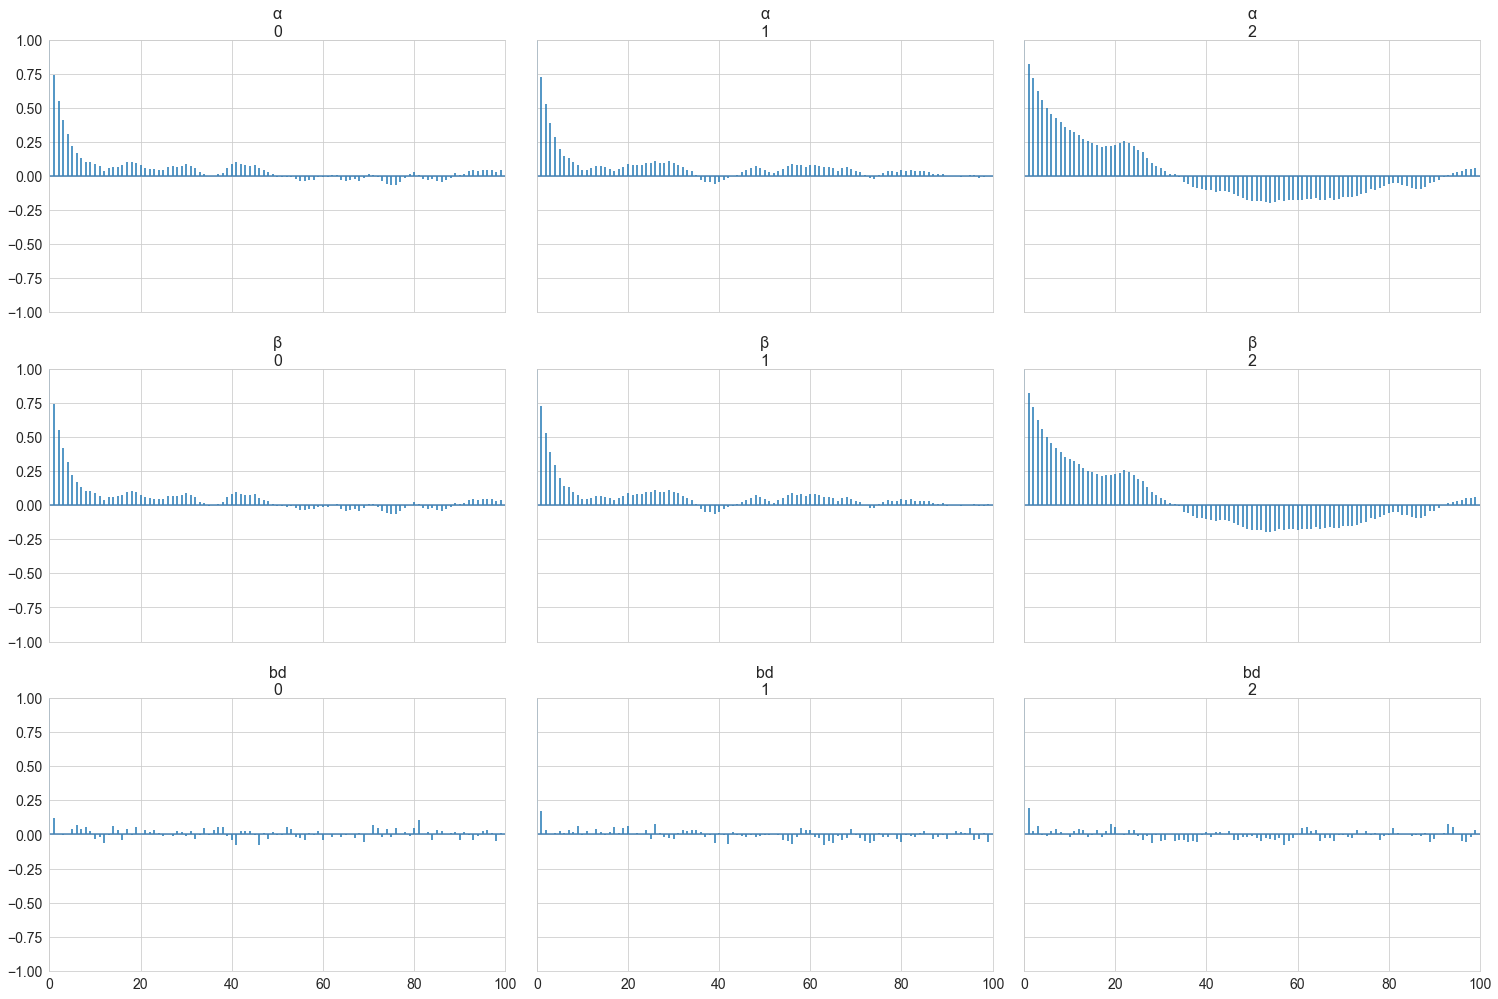

In [13]:
# еще раз почему плохо не сдвигать
with pm.Model() as model_1:
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=10) 
    μ = α + pm.math.dot(x_0, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    #θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β)
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1 = pm.sample(1000, step, start)
    
az.plot_autocorr(trace_1, ['α', 'β', 'bd']);
az.summary(trace_1, varnames)